# Predicting Blueberry Yield Using Machine Learning
# Brian Mann

## Introduction

Blueberries are an essential part of the breakfast table for many Americans. In terms of total fruit sales, blueberries account for over 5% of the market share$_{[4]}$. I am from Georgia, the nation’s top grower of blueberries. In 2021, Georgia growers accounted for 4.15 million pounds of cultivated blueberries valued at over \\$130 million$_{[5]}$. For the agricultural companies responsible for growing and harvesting them, it is critical to be able to predict how external factors influence crop yield. 

The overall goal of this project will be to generate a regression model that can accurately predict the yield of blueberries in an area given weather conditions and bee pollination density. We will utilize data derived from the Wild Blueberry Pollination Simulation Model$_{[1][2][3]}$, which is an open-source program that has been validated by field data collected in Maine and Canada. Although the data is simulated, it has generated samples based on real-world data used as input. 

Before beginning, it will be helpful to elaborate on some of the variables that will be used:

- **Clone size ($m^2$)**: represents the average area covered by the clones that the blueberries grow on, which can grow to hundreds of feet long.
- **Bee density ($m^2/min$)**: four variables represent the average density of some different types of bees - honey, bumble, andrena, and osmia. 
- **Temperature** ($^{\circ}F$): there are six temperature variables, which include the maximum, average, and minimum temperature recorded for all of the highs and lows during the growing season. 
- **Rain (days)**: two variables describe the number of days of rainfall and the average days of rainfall. 
- **Blueberry characteristics**: there are three variables related to the characteristics of the average blueberry - fruit set ($g$), fruit mass ($g$), and number of seeds. Fruit set is the first stage of fruit development where a fruit’s potential size is determined$_{[6]}$. 
- **Yield ($kg$)**: total mass of blueberries in the field, which is what we would like to predict. 

This project will be conducted in three phases. The first phase will include gathering the data, converting it into a dataframe, and performing some exploratory data analysis. The next phase will involve cleaning the data, assessing features, transforming features, and then selecting only the most relevant features for model building. The final phase will be to split the data into a training and test set, fit various regression models to the data, then select the model that best minimizes error between the expected and predicted results. 


### Sources ###

- [1] https://www.kaggle.com/competitions/playground-series-s3e14/
- [2] https://www.kaggle.com/datasets/shashwatwork/wild-blueberry-yield-prediction-dataset
- [3] https://data.mendeley.com/datasets/p5hvjzsvn8/1
- [4] https://www.ers.usda.gov/publications/pub-details/?pubid=107357
- [5] https://www.agmrc.org/commodities-products/fruits/blueberries
- [6] https://lodigrowers.com/improving-fruit-set/

In [436]:
### Imported Modules ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier, plot_tree
import warnings

In [406]:
# hide warnings
warnings.filterwarnings('ignore')
from sklearn.exceptions import ConvergenceWarning

## Part 1 - EDA

### General Characteristics of the Dataset

In [322]:
bbdf = pd.read_csv('blueberries.csv')
bbdf.head()

id  clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
0   0       25.0      0.50     0.25     0.75   0.50              69.7   
1   1       25.0      0.50     0.25     0.50   0.50              69.7   
2   2       12.5      0.25     0.25     0.63   0.63              86.0   
3   3       12.5      0.25     0.25     0.63   0.50              77.4   
4   4       25.0      0.50     0.25     0.63   0.63              77.4   

   MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  MinOfLowerTRange  \
0              42.1                  58.2              50.2              24.3   
1              42.1                  58.2              50.2              24.3   
2              52.0                  71.9              62.0              30.0   
3              46.8                  64.7              55.8              27.0   
4              46.8                  64.7              55.8              27.0   

   AverageOfLowerTRange  RainingDays  AverageRainingDays  fruitset  fruitmass  \
0                  41.2         24.0                0.39  0.425011   0.417545   
1                  41.2         24.0                0.39  0.444908   0.422051   
2                  50.8         24.0                0.39  0.552927   0.470853   
3                  45.8         24.0                0.39  0.565976   0.478137   
4                  45.8         24.0                0.39  0.579677   0.494165   

       seeds       yield  
0  32.460887  4476.81146  
1  33.858317  5548.12201  
2  38.341781  6869.77760  
3  39.467561  6880.77590  
4  40.484512  7479.93417

In [323]:
bbdf.shape

(15289, 18)

In [324]:
bbdf.dtypes

id                        int64
clonesize               float64
honeybee                float64
bumbles                 float64
andrena                 float64
osmia                   float64
MaxOfUpperTRange        float64
MinOfUpperTRange        float64
AverageOfUpperTRange    float64
MaxOfLowerTRange        float64
MinOfLowerTRange        float64
AverageOfLowerTRange    float64
RainingDays             float64
AverageRainingDays      float64
fruitset                float64
fruitmass               float64
seeds                   float64
yield                   float64
dtype: object

In [325]:
bbdf.describe()

id     clonesize      honeybee       bumbles       andrena  \
count  15289.000000  15289.000000  15289.000000  15289.000000  15289.000000   
mean    7644.000000     19.704690      0.389314      0.286768      0.492675   
std     4413.698468      6.595211      0.361643      0.059917      0.148115   
min        0.000000     10.000000      0.000000      0.000000      0.000000   
25%     3822.000000     12.500000      0.250000      0.250000      0.380000   
50%     7644.000000     25.000000      0.500000      0.250000      0.500000   
75%    11466.000000     25.000000      0.500000      0.380000      0.630000   
max    15288.000000     40.000000     18.430000      0.585000      0.750000   

              osmia  MaxOfUpperTRange  MinOfUpperTRange  AverageOfUpperTRange  \
count  15289.000000      15289.000000      15289.000000          15289.000000   
mean       0.592355         82.169887         49.673281             68.656256   
std        0.139489          9.146703          5.546405              7.641807   
min        0.000000         69.700000         39.000000             58.200000   
25%        0.500000         77.400000         46.800000             64.700000   
50%        0.630000         86.000000         52.000000             71.900000   
75%        0.750000         86.000000         52.000000             71.900000   
max        0.750000         94.600000         57.200000             79.000000   

       MaxOfLowerTRange  MinOfLowerTRange  AverageOfLowerTRange   RainingDays  \
count      15289.000000      15289.000000          15289.000000  15289.000000   
mean          59.229538         28.660553             48.568500     18.660865   
std            6.610640          3.195367              5.390545     11.657582   
min           50.200000         24.300000             41.200000      1.000000   
25%           55.800000         27.000000             45.800000     16.000000   
50%           62.000000         30.000000             50.800000     16.000000   
75%           62.000000         30.000000             50.800000     24.000000   
max           68.200000         33.000000             55.900000     34.000000   

       AverageRainingDays      fruitset     fruitmass         seeds  \
count        15289.000000  15289.000000  15289.000000  15289.000000   
mean             0.324176      0.502741      0.446553     36.164950   
std              0.163905      0.074390      0.037035      4.031087   
min              0.060000      0.192732      0.311921     22.079199   
25%              0.260000      0.458246      0.419216     33.232449   
50%              0.260000      0.506600      0.446570     36.040675   
75%              0.390000      0.560445      0.474134     39.158238   
max              0.560000      0.652144      0.535660     46.585105   

              yield  
count  15289.000000  
mean    6025.193999  
std     1337.056850  
min     1945.530610  
25%     5128.163510  
50%     6117.475900  
75%     7019.694380  
max     8969.401840

In [326]:
bbdf.isna().sum()

id                      0
clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

There are over 15,000 rows of data in this dataset, but due to it being synthetic, there are no missing entries. In addition, all of the variables are numeric. 

### Graphs

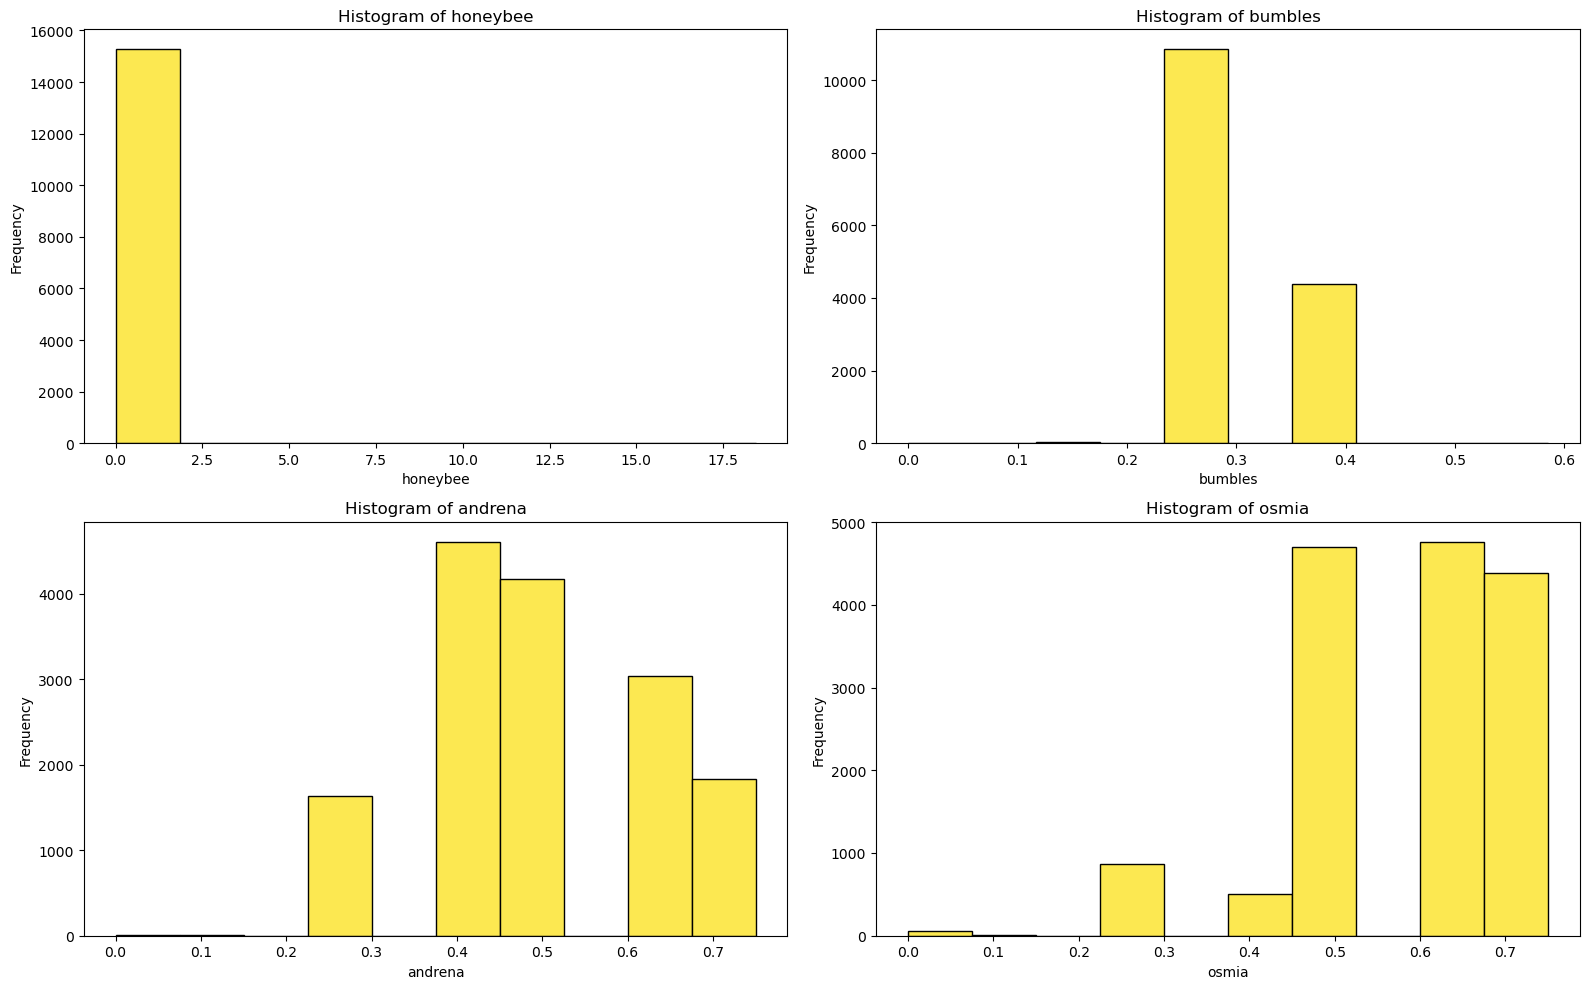

In [327]:
# set the columns
cols = ["honeybee", "bumbles", "andrena", "osmia"]
# create a 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
# plot the bee-related histograms
for i, col in enumerate(cols):
    xx, yy = divmod(i, 2)
    axes[xx, yy].hist(bbdf[col], edgecolor='black', linewidth=1, color='#fce851')
    axes[xx, yy].set_title(f"Histogram of {col}")
    axes[xx, yy].set_xlabel(col)
    axes[xx, yy].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

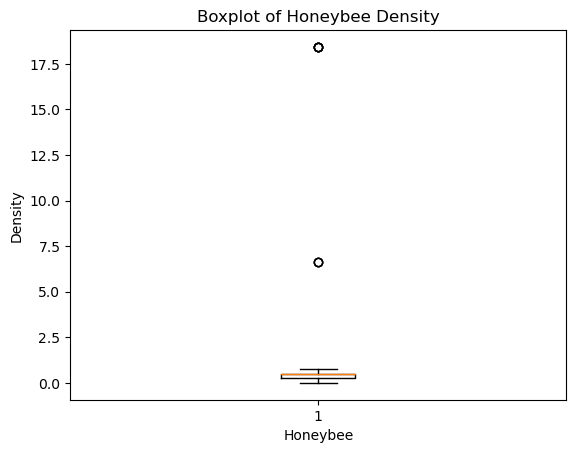

In [328]:
# create a boxplot for honeybee density, assessing outliers
plt.boxplot(bbdf.honeybee)
plt.title('Boxplot of Honeybee Density')
plt.ylabel('Density')
plt.xlabel('Honeybee')
plt.show()

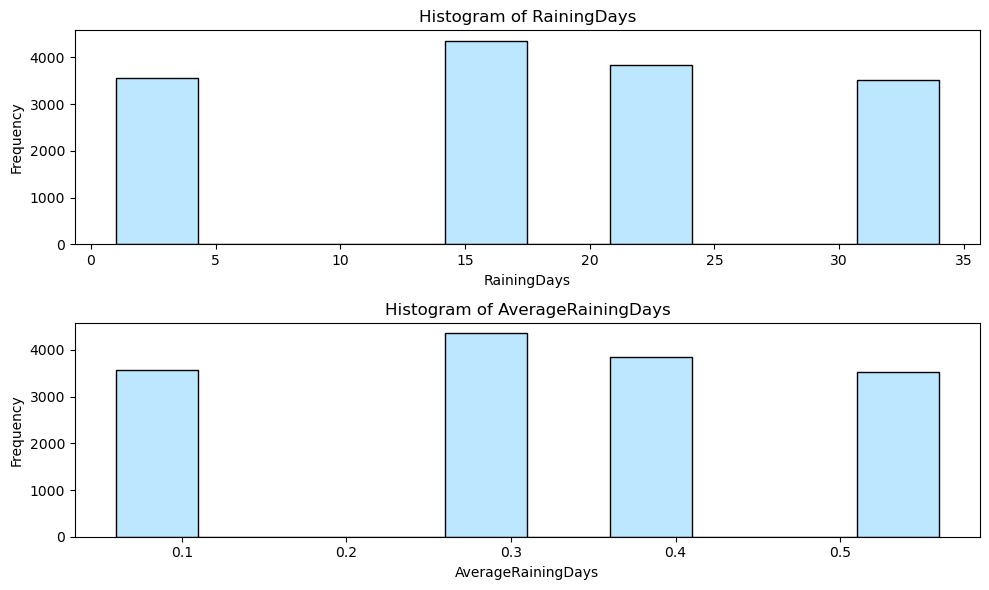

In [329]:
# set columns 
cols = ["RainingDays", "AverageRainingDays"]
# create a 2x1 plot
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
# plot the rain-related histograms
for i, col in enumerate(cols):
    axes[i].hist(bbdf[col], edgecolor='black', linewidth=1, color='#bde7ff')
    axes[i].set_title(f"Histogram of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")
    
plt.tight_layout()
plt.show()

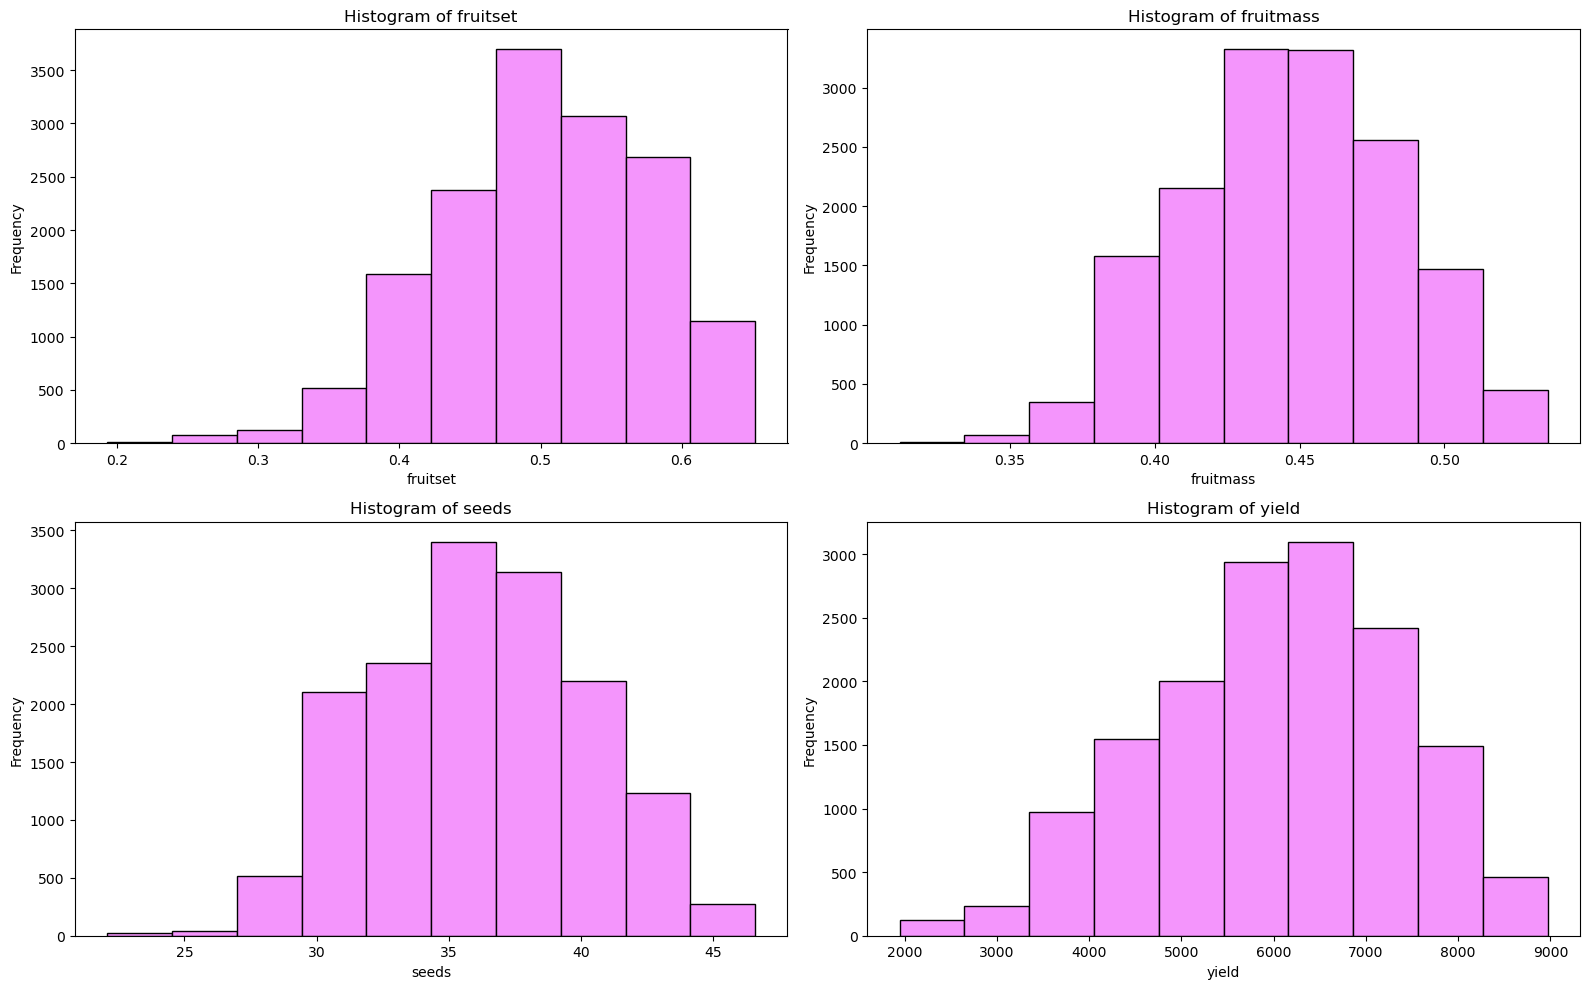

In [330]:
# set the columns
cols = ["fruitset", "fruitmass", "seeds", "yield"]
# create a 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
# plot the fruit-related histograms
for i, col in enumerate(cols):
    xx, yy = divmod(i, 2)
    axes[xx, yy].hist(bbdf[col], edgecolor='black', linewidth=1, color='#f495fc')
    axes[xx, yy].set_title(f"Histogram of {col}")
    axes[xx, yy].set_xlabel(col)
    axes[xx, yy].set_ylabel("Frequency")
    
plt.tight_layout()
plt.show()

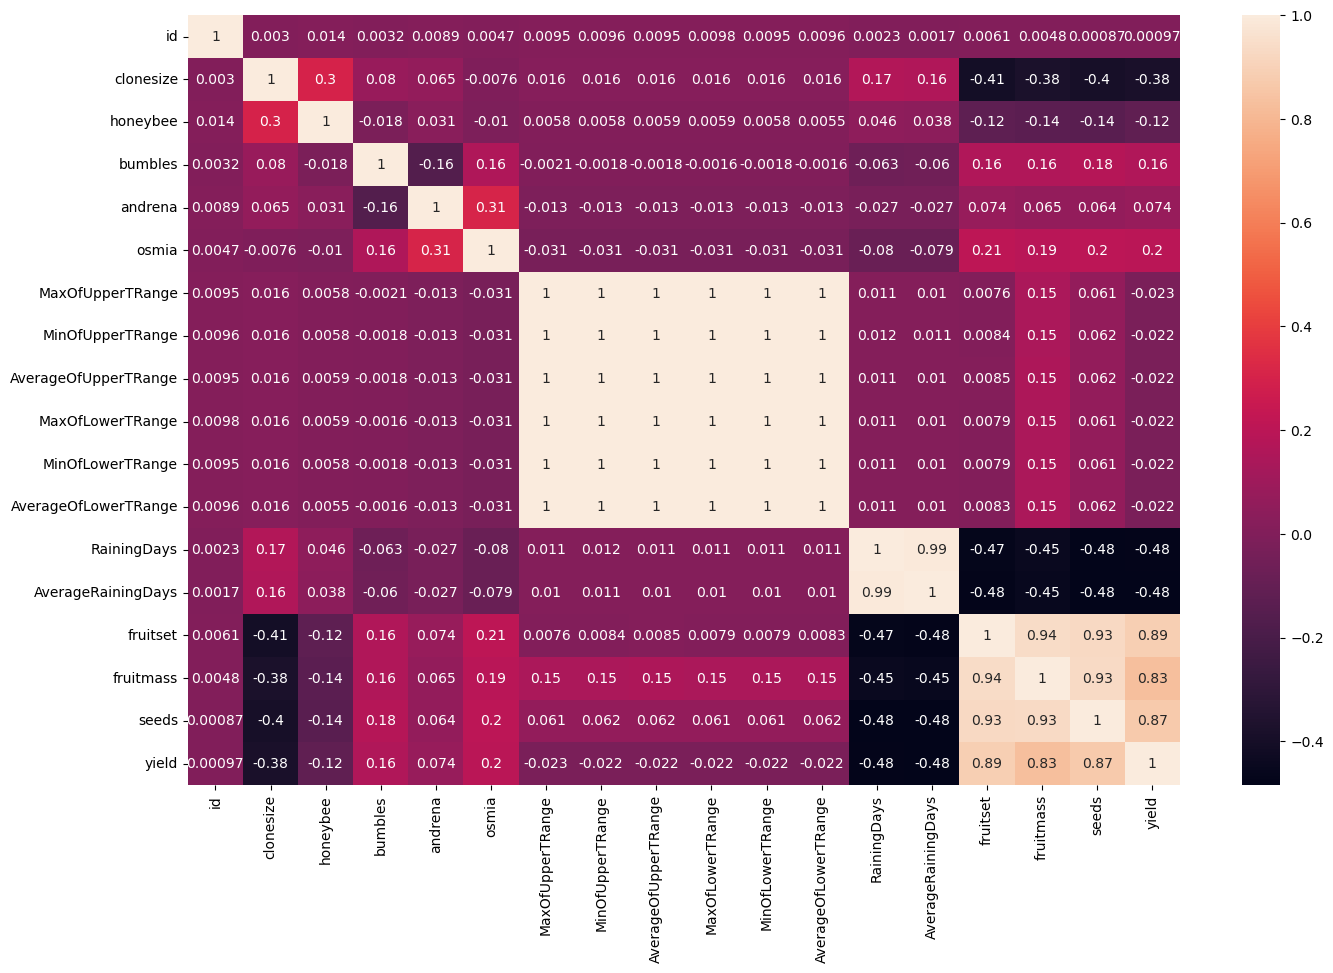

In [331]:
# get the correlation of every variable
cor = bbdf.corr()
# plot the heatmap using seaborn
plt.figure(figsize=(16,10))
sns.heatmap(cor, annot=True)
plt.show()

Due to there being so many variables here, it can be frustrating to try to read this chart. 

Let's make it clearer by separating this correlation matrix into different categories and comparing each of them with yield:

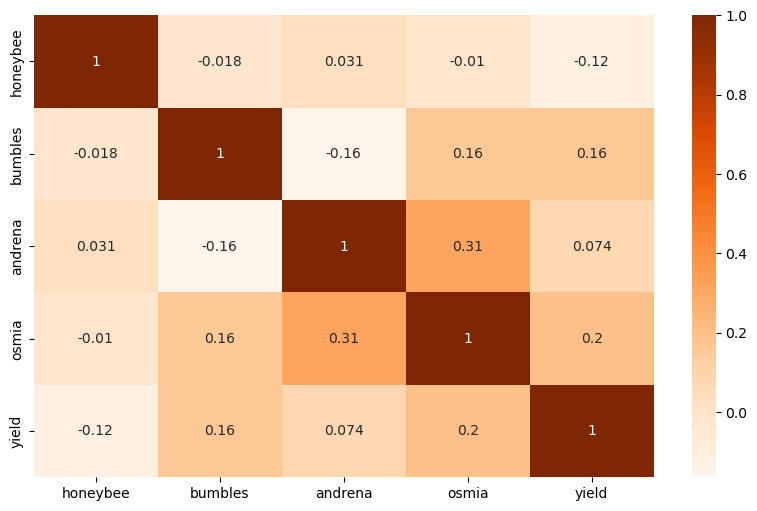

In [332]:
# plot the bee correlation with yield
bee_cor = bbdf.loc[:, ["honeybee", "bumbles", "andrena", "osmia", "yield"]].corr()
plt.figure(figsize=(10,6))
sns.heatmap(bee_cor, annot=True, cmap='Oranges')
plt.show()

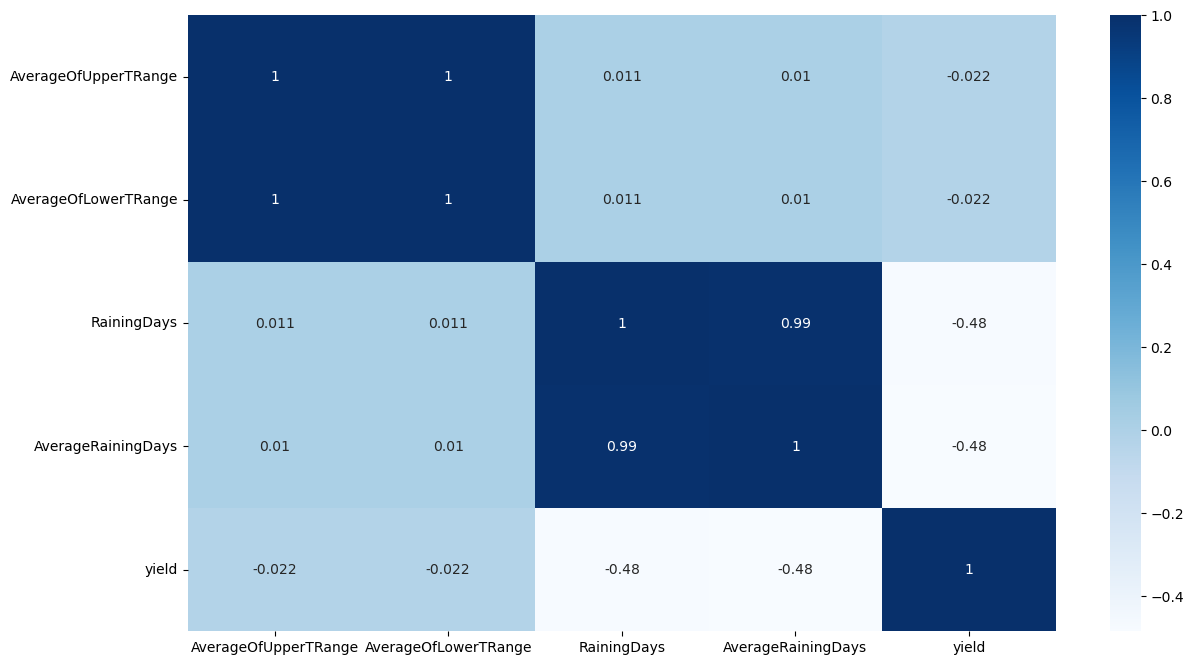

In [333]:
# plot the weather correlation with yield
wthr_cor = bbdf.loc[:, ["AverageOfUpperTRange", "AverageOfLowerTRange", "RainingDays", 
                        "AverageRainingDays", "yield"]].corr()
plt.figure(figsize=(14,8))
sns.heatmap(wthr_cor, annot=True, cmap='Blues')
plt.show()

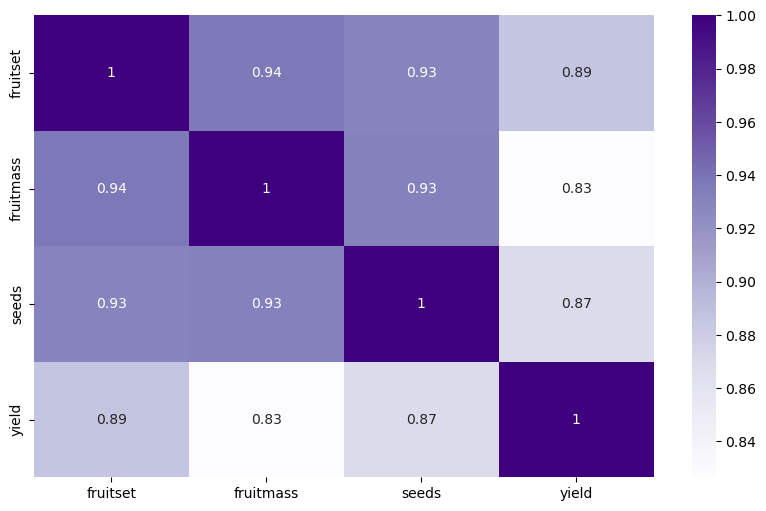

In [334]:
# plot the fruit info correlation with yield
fruit_cor = bbdf.loc[:, ["fruitset", "fruitmass", "seeds", "yield"]].corr()
plt.figure(figsize=(10,6))
sns.heatmap(fruit_cor, annot=True, cmap='Purples')
plt.show()

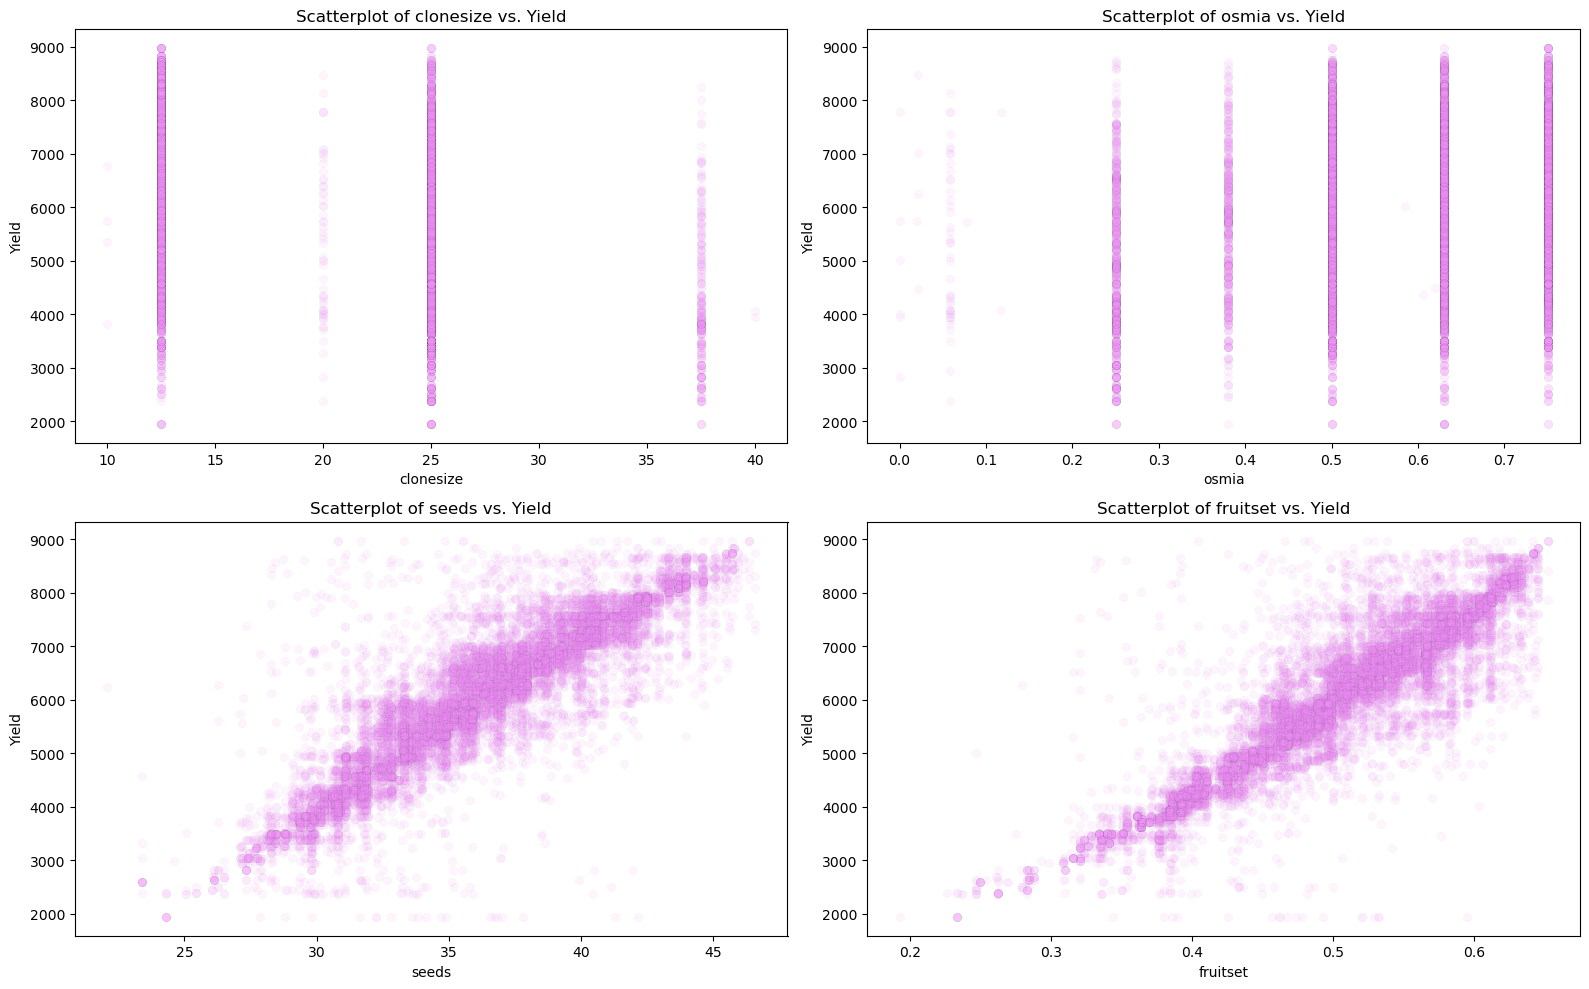

In [335]:
# set the columns
cols = ["clonesize", "osmia", "seeds", "fruitset"]
# set size to 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
# plot each of the columns as a scatterplot against yield
for i, col in enumerate(cols):
    xx, yy = divmod(i, 2)
    axes[xx, yy].scatter(bbdf[col], bbdf['yield'], color='#f495fc', edgecolors='black', linewidth=0.1, alpha=0.1)
    axes[xx, yy].set_title(f"Scatterplot of {col} vs. Yield")
    axes[xx, yy].set_xlabel(col)
    axes[xx, yy].set_ylabel("Yield")
    
plt.tight_layout()
plt.show()

### Analysis of Graphs

The first set of graphs are histograms for each of the three primary categories of variables - bees, weather, and fruit characteristics. Aside from the honeybees, each bee type seems to have densities lying on only a few discrete bins between 0.2-0.7. As for the honeybees, there seem to be a couple of outliers far above the norm, as evidenced by the boxplot. These will be considered in the subsequent phase. A similar story can be found with the number & average of rainy days. There appear to be many repeat values in only a handful of bins. Additionally, the distribution of rainy days seems to be roughly equal among those bins. On the other hand, fruit mass, fruit set, seeds and yield all seem to be following a mostly normal distribution, all with a slightly left/negative skew. 

The next set of graphs are of correlation values among the various variables. The first correlation matrix is one comparing all 18 values to one another. Since this is quite difficult to read, the values were separated into the same three categories as before. None of the bee densities has much of a correlation with yield, with osmia having the highest with only +0.2. Temperature had close to zero correlation with yield, but the number of raining days had a moderate negative correlation (-0.48), indicating that the blueberries may have benefitted from more days in the sun. Unsurprisingly, each of fruit set, fruit mass, seeds and yield all had a very high positive correlation (+0.83-0.94) with each other. This shows that bigger, riper berries with more seeds are a very indicative of having a high yield. 

Lastly, a few different variables (clonesize, osmia, seeds, and fruitset) were plotted in scatterplots against yield. Similarly to how the histograms had shown, there seem to be only a few discrete values that the vast majority of datapoints fall into for the osmia bees and clonesize. This is most likely also true for the rest of the bees and the number of rainy days. On the othe hand, fruitset and seeds had a much broader and continuous range of values, with a clear positive linear relationship. This supports the data given from the correlation plots. 

In the next phase, it may be beneficial to transform some of the bee values, clonesize or raining days into dummy variables for each of the most common value ranges. There may be a correlation that is missed due to so many repeat values. 

## Part 2 - Data Prep

In [336]:
# printing the dataset once again for reference
bbdf.head()

id  clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
0   0       25.0      0.50     0.25     0.75   0.50              69.7   
1   1       25.0      0.50     0.25     0.50   0.50              69.7   
2   2       12.5      0.25     0.25     0.63   0.63              86.0   
3   3       12.5      0.25     0.25     0.63   0.50              77.4   
4   4       25.0      0.50     0.25     0.63   0.63              77.4   

   MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  MinOfLowerTRange  \
0              42.1                  58.2              50.2              24.3   
1              42.1                  58.2              50.2              24.3   
2              52.0                  71.9              62.0              30.0   
3              46.8                  64.7              55.8              27.0   
4              46.8                  64.7              55.8              27.0   

   AverageOfLowerTRange  RainingDays  AverageRainingDays  fruitset  fruitmass  \
0                  41.2         24.0                0.39  0.425011   0.417545   
1                  41.2         24.0                0.39  0.444908   0.422051   
2                  50.8         24.0                0.39  0.552927   0.470853   
3                  45.8         24.0                0.39  0.565976   0.478137   
4                  45.8         24.0                0.39  0.579677   0.494165   

       seeds       yield  
0  32.460887  4476.81146  
1  33.858317  5548.12201  
2  38.341781  6869.77760  
3  39.467561  6880.77590  
4  40.484512  7479.93417

In [337]:
# get rid of the id column
bbdf.drop(columns=['id'], inplace=True)

The id column serves little to no purpose in creating a model, so we can exclude it. 

In [338]:
# change column names to snake_case and modify names for brevity
bbdf.columns = ['clonesize', 'honey', 'bumble', 'andrena', 'osmia',
       'high_max', 'high_min', 'high_avg',
       'low_max', 'low_min', 'low_avg',
       'rain_days', 'rain_avg', 'fruitset', 'fruitmass', 'seeds',
       'yield']

In [339]:
# get rid of rain_days since we already have rain_avg
bbdf.drop(columns=['rain_days'], inplace=True)

Because the rain_days column and the rain_avg column are essentially two ways of describing the same quantity, we really only need to keep one of these columns in the final dataframe. 

In [340]:
# remove the outliers from the honeybee column, as we saw in Milestone 1
bbdf = bbdf[bbdf.honey < 1]

The boxplot from milestone 1 showed us that there were a handful of outliers in the data for the honeybee column. We opted to simply get rid of the rows that contained them, as there seemed to be no major influence on the yield. 

In [341]:
# find the difference between the highest and lowest temperatures and store
# it as a separate variable
bbdf['temp_diff'] = round(bbdf.high_max - bbdf.low_min, 2)

In [342]:
# drop the other temperature-related columns, as they are all highly correlated with
# one another, potentially skewing the regression results
bbdf.drop(columns=['high_max', 'high_min', 'high_avg', 'low_max', 'low_min', 'low_avg'], 
          inplace=True)

As we also saw from the correlation plot in milestone 1, all of the temperature data was highly correlated with all of the other temperature data. In order to mitigate the potential for multicolinearity in our regression analysis, we opted to create a separate variable that tracks the difference between the highest and lowest temperatures, while simultaneously dropping all of the other temperature variables. 

In [343]:
# rearrange the temp_diff column so that all the columns with highly repeated values
# are grouped together
bbdf = pd.concat([bbdf.loc[:, 'clonesize':'rain_avg'], 
                  bbdf.temp_diff, bbdf.loc[:, 'fruitset':'yield']], axis='columns')

In [344]:
# verify the lack of missing values
bbdf.isna().sum()

clonesize    0
honey        0
bumble       0
andrena      0
osmia        0
rain_avg     0
temp_diff    0
fruitset     0
fruitmass    0
seeds        0
yield        0
dtype: int64

Since this data was synthetically generated based off of real-world input, there were no missing entries. This is verified here. 

In [413]:
# create a copy of the dataframe to be used for making dummy variables
# this way they can be kept separate for comparison analysis
dumbb = bbdf.copy()

In [414]:
# take a look at the number of unique values in each column
# as we can see, there are many repeated values in the first several columns
for col in dumbb.columns:
    print(dumbb[col].unique().size)

6
5
11
15
14
7
8
1525
1513
2064
776


Despite all of the variables in the dataframe being numeric, there are a significant number of repeated values for clone size, temperature, rain, and all of the bee-related columns. In order to better reflect the pseudo-categorical nature of the data, we will create two separate sets of data - one for the original features, and one of one-hot encoded features. 

In [415]:
# create dummy variables for the columns with many repeat values
dumbb = pd.get_dummies(dumbb, columns=dumbb.loc[:, 'clonesize':'temp_diff'].columns, drop_first=True)

In [416]:
# split the data into training and test data for the original df
X_train, X_test, y_train, y_test = train_test_split(
    bbdf.drop(columns=['yield']), bbdf['yield'], test_size=0.2, random_state=8020)

In [417]:
# split the data into training and test data for the dummy-variable df
W_train, W_test, z_train, z_test = train_test_split(
    dumbb.drop(columns=['yield']), dumbb['yield'], test_size=0.2, random_state=8020)

The last few steps of preparing the data will be to set up a PCA and a variance threshold that can be used for feature extraction/selection during the modeling phase. 

In [456]:
# this function generates a PCA for some given training data, 
# as well as printing out the original and new number of features
def create_fitted_pca(training_data, threshold=0.9):
    # create a scaler and fit the data to it
    scaler = StandardScaler()
    features = scaler.fit_transform(training_data)
    # create a PCA with a given threshold and fit the features
    pca = PCA(n_components=threshold, whiten=True)
    fpca = pca.fit_transform(features)
    print(f'Original # of features: {features.shape[1]}')
    print(f'New # of features: {fpca.shape[1]}')
    return pca

In [448]:
# make a PCA for the original df
X_pca = create_fitted_pca(X_train)

Original # of features: 10
New # of features: 6


In [449]:
# make a PCA for the dummy df
W_pca = create_fitted_pca(W_train)

Original # of features: 62
New # of features: 36


In [457]:
# this function generates a Variance Threshold for some given training data, 
# as well as printing out the original and new number of features
def create_fitted_vthresh(training_data, threshold=0.1):
    # create a min-max scaler and fit the data to it
    mms = MinMaxScaler()
    features = mms.fit_transform(training_data)
    # create a variance threshold with a given threshold and fit the features
    vthresh = VarianceThreshold(threshold)
    fv = vthresh.fit_transform(features)
    print(f'Original # of features: {features.shape[1]}')
    print(f'New # of features: {fv.shape[1]}')
    return vthresh

In [450]:
# make a variance threshold for the original df
X_vthresh = create_fitted_vthresh(X_train)

Original # of features: 10
New # of features: 2


In [451]:
# make a variance threshold for the dummy df
W_vthresh = create_fitted_vthresh(W_train)

Original # of features: 62
New # of features: 20


### Summary of Data Preparation:

- Dropped unnecessary columns
- Changed column names
- Created a new column
- Omitted outliers
- Checked for missing values
- Created a one-hot encoding for certain features
- Split data into training/test sets
- Created PCAs and variance thresholds

## Part 3 - Modeling Pipeline

In [424]:
# create a pipeline for a scale and model
pipe = Pipeline([('scale', StandardScaler()), ('model', LinearRegression())])

In [442]:
# set up a search space for linear regression and ridge regression
search_space = [{'model': [LinearRegression()]},
               {'model': [Ridge(max_iter=10000)], 
                'model__alpha': np.logspace(-4, 4, 50)}]

In [443]:
# make a grid search cross-validation with 5-folds over the pipe and search space
grid_search = GridSearchCV(pipe, search_space, cv=5, n_jobs=-1, verbose=0, scoring='neg_mean_squared_error')

In [444]:
# this function takes in training and testing variables, fits 
# them to the grid search model, and prints out various results
def run_tests(x, xt, y, yt):
    # fit the training data to the grid search
    gs = grid_search.fit(x, y)
    # get the best estimator
    be = gs.best_estimator_
    print(f'Best estimator: {be}')
    print(f'Best score:, {-gs.best_score_}')
    # make a prediction using the test data
    pred = be.predict(xt)
    # get R^2 and RMSE
    r2 = r2_score(yt, pred)
    rmse = np.sqrt(mean_squared_error(yt, pred))
    print(f"R^2: {r2}")
    print(f"RMSE: {rmse}")

In [445]:
# original data / no transformation
run_tests(X_train, X_test, y_train, y_test)

Best estimator: Pipeline(steps=[('scale', StandardScaler()),
                ('model', Ridge(alpha=3.727593720314938, max_iter=10000))])
Best score:, 343378.2066988281
R^2: 0.8184196637666578
RMSE: 575.1107168428666


In [434]:
# dummy-variable data / no transformation
run_tests(W_train, W_test, z_train, z_test)

Best estimator: Pipeline(steps=[('scale', StandardScaler()),
                ('model', Ridge(alpha=24.420530945486497, max_iter=10000))])
Best score:, 341346.2108997434
R^2: 0.8198371991362279
RMSE: 572.8614724732855


In [459]:
# extract the original and dummy-variable data using a PCA
fX = StandardScaler().fit_transform(X_test)
fW = StandardScaler().fit_transform(W_test)
pX = X_pca.transform(fX)
pW = W_pca.transform(fW)

In [461]:
# original data / PCA extraction
run_tests(pX, pX, y_test, y_test)

Best estimator: Pipeline(steps=[('scale', StandardScaler()),
                ('model', Ridge(alpha=0.0004498432668969444, max_iter=10000))])
Best score:, 377777.1523242443
R^2: 0.7932867897335437
RMSE: 613.6223482743276


In [462]:
# dummy-variable data / PCA extraction
run_tests(pW, pW, z_test, z_test)

Best estimator: Pipeline(steps=[('scale', StandardScaler()),
                ('model', Ridge(alpha=2.559547922699533, max_iter=10000))])
Best score:, 780176.5094166994
R^2: 0.8082181701781236
RMSE: 591.0453181569021


In [460]:
# select the original and dummy-variable data using a variance threshold
mX = MinMaxScaler().fit_transform(X_test)
mW = MinMaxScaler().fit_transform(W_test)
vX = X_vthresh.transform(mX)
vW = W_vthresh.transform(mW)

In [464]:
# adjust the pipeline to use a min-max scaler
pipe = Pipeline([('scale', MinMaxScaler()), ('model', LinearRegression())])
grid_search = GridSearchCV(pipe, search_space, cv=5, n_jobs=-1, verbose=0, scoring='neg_mean_squared_error')

In [465]:
# original data / VTHRESH selection
run_tests(vX, vX, y_test, y_test)

Best estimator: Pipeline(steps=[('scale', MinMaxScaler()),
                ('model', Ridge(alpha=0.8286427728546842, max_iter=10000))])
Best score:, 1412362.3803676045
R^2: 0.22602384883782556
RMSE: 1187.3557012623774


In [466]:
# dummy-variable data / VTHRESH selection
run_tests(vW, vW, z_test, z_test)

Best estimator: Pipeline(steps=[('scale', MinMaxScaler()),
                ('model', Ridge(alpha=5.428675439323859, max_iter=10000))])
Best score:, 1128768.4334042147
R^2: 0.3888870245150222
RMSE: 1055.0615714846165


In [473]:
# read in a CSV file containing the results of all of the model testings
# and cross-validation
mrts = pd.read_csv('model_results.csv')
mrts = mrts.dropna(how='all').dropna(axis=1, how='all')

In [474]:
mrts

DUMMY TRANSFORMATION  FEATURES  MODEL      ALPHA        R2         RMSE
0  False           NONE      10.0  RIDGE   3.727594  0.818420   575.110717
1   True           NONE      62.0  RIDGE  24.420531  0.819837   572.861472
2  False            PCA       6.0  RIDGE   0.000450  0.793287   613.622348
3   True            PCA      36.0  RIDGE   2.559548  0.808218   591.045318
4  False        VTHRESH       2.0  RIDGE   0.828643  0.226024  1187.355701
5   True        VTHRESH      20.0  RIDGE   5.428675  0.388887  1055.061571

### Results of Model Testing

The target variable that we would like to predict is blueberry yield, which is a real-valued numeric quantity. In this case, linear regression was a clear choice for a starting point, as it is simple and easily interpretable. Ridge regression was added to further improve model building due to its improved feature selection and reduction of overfitting. Additionally, lasso regression was also added, but due to issues with convergence - possibly due to multicolinearity - it was dropped. 

Grid search cross-validations were conducted across two sets of training/test features (dummy-transformed and original) and three types of transformations (PCA, variance threshold, and no selection/extraciton). Ridge regression was a clear winner in every test, unsurprisingly, as linear regression was simply used as a baseline. In both the R^2 and RMSE metrics, the dummy-transformed features out-performed the original features in each test. Despite this, the improvements were relatively slim. The PCA extraction did not produce an improvement in R^2 or RMSE, nor did the variance threshold, although the variance threshold produced significantly worse results than all other models. 

In the end, the dummy-transformed features with no selection/extraction produced the lowest RMSE (572.8) and the highest R^2 (0.819). However, only using the original features produced nearly the same result (RMSE 575.1 and R^2 0.818). Considering that the dummy-transformed data included 52 more features than the original data, with larger volumes of data, it may be more efficient to forgo this type of transformation. Therefore, it is recommended that the first ridge regression model be used with the original non-transformed features. 